<a href="https://colab.research.google.com/github/jeonbyeongguk/cuckoobee/blob/main/AIbootcamp/Project/Fashion_Campus_%EB%A7%A4%EC%B6%9C%EA%B0%90%EC%86%8C%EC%97%90_%EB%94%B0%EB%A5%B8_%EB%A6%AC%ED%85%90%EC%85%98_%EA%B0%95%ED%99%94_%EC%A0%84%EB%9E%B5_%EC%A0%9C%EC%95%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import files
#uploaded = files.upload() 
#product.to_csv("/content/drive/MyDrive/colab_data/Fashion Campus/product.csv", index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

transaction_new = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/transaction_new.csv")
customer = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/customer.csv")
#click_stream_new = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/click_stream_new.csv")
#product = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/product.csv")
#product.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)
#product.rename(columns={'id': 'product_id'}, inplace=True)

In [ ]:
transaction_new = transaction_new[transaction_new['payment_status'] == 'Success']
df = transaction_new.groupby(['customer_id', 'created_at']).sum()
df['total_amount2'] = df['quantity'] * df['item_price']
# customer_id를 다시 칼럼으로 변환
df = df.reset_index()

# index를 0부터 시작하도록 설정
df.index = df.index - df.index.min()

# df 데이터프레임에서 total_amount2 칼럼을 기준으로 내림차순으로 정렬
df = df.sort_values(by='total_amount2', ascending=True)

In [ ]:
import pandas as pd

# total_amount2 칼럼의 상위 4%, 16%, 30% 값을 구한다
top_4_percent = df["total_amount2"].quantile(0.96)
top_16_percent = df["total_amount2"].quantile(0.80)
top_30_percent = df["total_amount2"].quantile(0.5)

# VVIP, VIP, GOOD, NORMAL 그룹을 나눈다
def get_customer_group(row):
    if row["total_amount2"] > top_4_percent:
        return "VVIP"
    elif row["total_amount2"] > top_16_percent:
        return "VIP"
    elif row["total_amount2"] > top_30_percent:
        return "GOOD"
    else:
        return "NORMAL"

# 각 고객별 그룹을 구하고, 새로운 칼럼으로 추가한다
df["customer_group"] = df.apply(get_customer_group, axis=1)


In [ ]:
#df.to_csv('df.csv', index=False, encoding='utf-8-sig')

In [ ]:
df.groupby('customer_group').mean()

,customer_id,promo_amount,shipment_fee,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_amount2
customer_group,,,,,,,,,,
GOOD,49891.482926,2176.564250,9863.881660,-5.480470,118.910406,4.621063e+05,31830.731869,1.495688,3.438844e+05,4.543895e+05
NORMAL,49853.817711,2047.271332,9171.487117,-5.113882,110.987465,2.008960e+05,29689.612919,1.032516,1.904501e+05,1.937718e+05
VIP,49755.395285,4465.220889,20191.912925,-11.145583,242.406481,2.372666e+06,64875.826401,4.410252,5.792299e+05,2.358451e+06
VVIP,49889.967462,15628.604338,68967.646068,-38.478295,835.072995,2.807436e+07,223388.219982,12.538926,1.920850e+06,2.805337e+07


In [ ]:
df.customer_group.value_counts(normalize=True) * 100

NORMAL    50.000245
GOOD      29.999730
VIP       15.999971
VVIP       4.000054
Name: customer_group, dtype: float64

<Axes: >

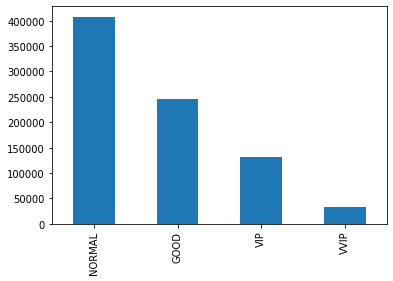

In [ ]:
df['customer_group'].value_counts().plot(kind='bar')

## 코호트 분석

### 전체 리텐션

In [ ]:
import pandas as pd
customer_purchase = pd.read_csv('/content/drive/MyDrive/colab_data/Fashion Campus/customer_purchase.csv')
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
customer_purchase['after_created_at'] = pd.to_datetime(customer_purchase['after_created_at'])

customer_purchase = customer_purchase.sort_values(['customer_id', 'created_at'])
customer_purchase['purchase_diff'] = (customer_purchase['after_created_at'] - customer_purchase['created_at']).dt.days

customer_purchase = customer_purchase[['customer_id', 'customer_group', 'created_at', 'after_created_at', 'purchase_diff']]

last_indices = customer_purchase.sort_values(['customer_id', 'created_at']).groupby('customer_id').tail(1).index
customer_purchase = customer_purchase.drop(last_indices)

customer = customer[['customer_id','first_join_date']]
customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])
customer['first_join_month'] = customer['first_join_date'].dt.to_period('M')

customer_purchase = pd.merge(customer_purchase, customer, on='customer_id', how='outer')
customer_purchase.dropna(subset=['created_at'], inplace=True)
#customer_purchase = customer_purchase[['customer_id', 'customer_group','first_join_month','first_join_date','created_at']]
customer_purchase = customer_purchase[['customer_id', 'customer_group', 'created_at', 'first_join_date', 'purchase_diff']]
customer_purchase = customer_purchase[(customer_purchase['created_at'] >= '2022-02-01')&(customer_purchase['created_at'] <= '2022-07-31') ]
cp = customer_purchase 

<ipython-input-58-9d4c512c2c8e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])


<ipython-input-85-197aa0b2c943>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
<ipython-input-85-197aa0b2c943>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])


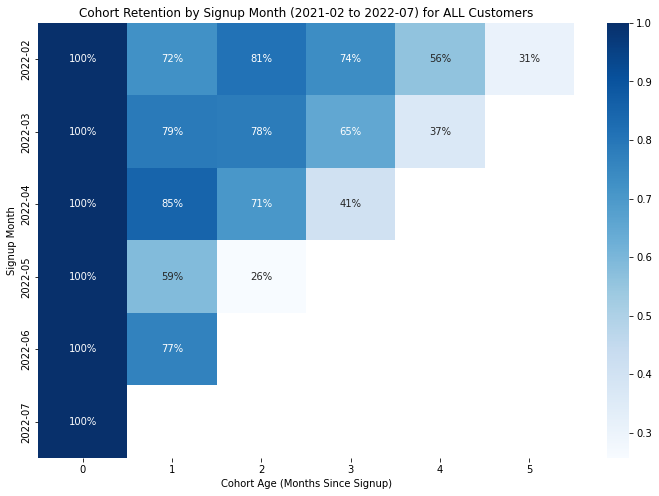

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_purchase = cp

# 필요한 칼럼 선택
customer_purchase = customer_purchase[['customer_id', 'customer_group','first_join_date','created_at']]

# 날짜 형식으로 변환
customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])

# 코호트 기준 월 추출
customer_purchase['first_join_month'] = customer_purchase['first_join_date'].dt.to_period('M')
customer_purchase['created_month'] = customer_purchase['created_at'].dt.to_period('M')

# 코호트 기간 계산
customer_purchase['cohort_period'] = customer_purchase['created_month'].astype(int) - customer_purchase['first_join_month'].astype(int)

# 필터링 - 2022년 2월 1일부터 2022년 7월 31일까지 데이터만 사용
start_date = pd.to_datetime('2022-02-01')
end_date = pd.to_datetime('2022-07-31')
customer_purchase = customer_purchase[(customer_purchase['first_join_date'] >= start_date) & (customer_purchase['first_join_date'] <= end_date)]

# 각 코호트 그룹별 고객 수 계산
cohort_group_size = customer_purchase.groupby(['first_join_month', 'cohort_period'])['customer_id'].nunique()
cohort_group_size = cohort_group_size.reset_index()

# 각 코호트 그룹별 리텐션 수 계산
cohort_retention = cohort_group_size.pivot(index='first_join_month', columns='cohort_period', values='customer_id')
cohort_size = cohort_retention.iloc[:,0]
retention_matrix = cohort_retention.divide(cohort_size, axis=0)

# 100% 초과하는 값을 100%로 변경
retention_matrix = retention_matrix.applymap(lambda x: 1 if x > 1 else x)

# 코호트 리텐션 차트 그리기
plt.figure(figsize=(12, 8))

sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention by Signup Month (2021-02 to 2022-07) for ALL Customers')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Signup Month')
plt.xticks(np.arange(6) + 0.5, labels=['0', '1', '2', '3', '4', '5'])
plt.yticks(np.arange(len(retention_matrix)) + 0.5, labels=retention_matrix.index.strftime('%Y-%m'))
plt.show()


### VVIP 리텐션 그래프 

<ipython-input-86-1a5c714923d8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
<ipython-input-86-1a5c714923d8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
<ipython-input-86-1a5c714923d8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

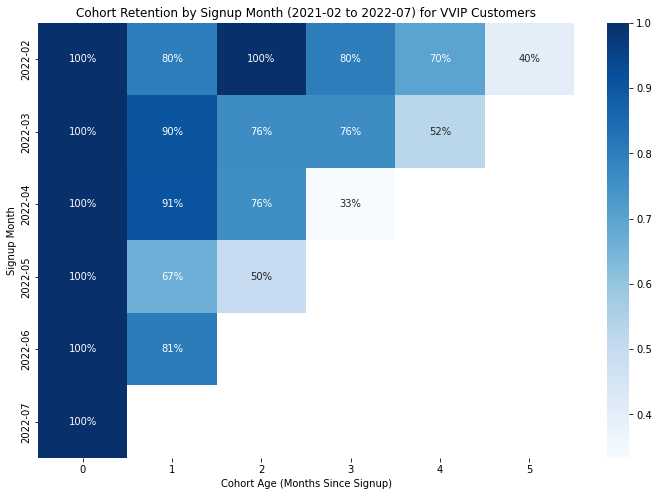

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_purchase = cp

# 필요한 칼럼 선택
customer_purchase = customer_purchase[ customer_purchase.customer_group == 'VVIP']

# 날짜 형식으로 변환
customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])

# 코호트 기준 월 추출
customer_purchase['first_join_month'] = customer_purchase['first_join_date'].dt.to_period('M')
customer_purchase['created_month'] = customer_purchase['created_at'].dt.to_period('M')

# 코호트 기간 계산
customer_purchase['cohort_period'] = customer_purchase['created_month'].astype(int) - customer_purchase['first_join_month'].astype(int)

# 필터링 - 2022년 2월 1일부터 2022년 7월 31일까지 데이터만 사용
start_date = pd.to_datetime('2022-02-01')
end_date = pd.to_datetime('2022-07-31')
customer_purchase = customer_purchase[(customer_purchase['first_join_date'] >= start_date) & (customer_purchase['first_join_date'] <= end_date)]

# 각 코호트 그룹별 고객 수 계산
cohort_group_size = customer_purchase.groupby(['first_join_month', 'cohort_period'])['customer_id'].nunique()
cohort_group_size = cohort_group_size.reset_index()

# 각 코호트 그룹별 리텐션 수 계산
cohort_retention = cohort_group_size.pivot(index='first_join_month', columns='cohort_period', values='customer_id')
cohort_size = cohort_retention.iloc[:,0]
retention_matrix = cohort_retention.divide(cohort_size, axis=0)

# 100% 초과하는 값을 100%로 변경
retention_matrix = retention_matrix.applymap(lambda x: 1 if x > 1 else x)

# 코호트 리텐션 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention by Signup Month (2021-02 to 2022-07) for VVIP Customers')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Signup Month')
plt.xticks(np.arange(6) + 0.5, labels=['0', '1', '2', '3', '4', '5'])
plt.yticks(np.arange(len(retention_matrix)) + 0.5, labels=retention_matrix.index.strftime('%Y-%m'))
plt.show()


### VIP 리텐션

<ipython-input-45-ce0509d837e0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
<ipython-input-45-ce0509d837e0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
<ipython-input-45-ce0509d837e0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

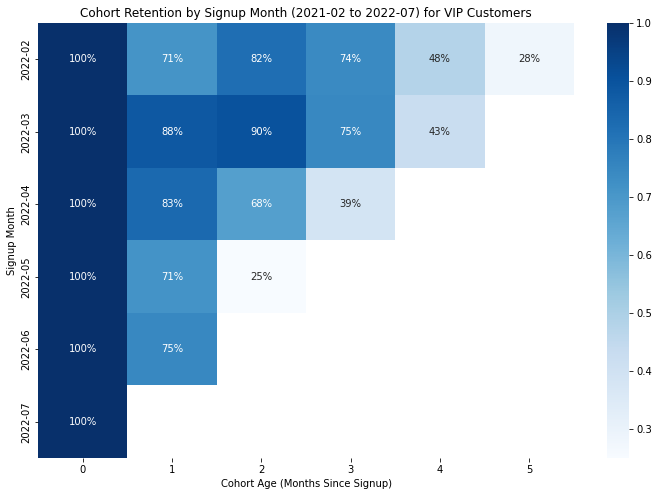

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_purchase = cp

# 필요한 칼럼 선택
customer_purchase = customer_purchase[ customer_purchase.customer_group == 'VIP']

# 날짜 형식으로 변환
customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])

# 코호트 기준 월 추출
customer_purchase['first_join_month'] = customer_purchase['first_join_date'].dt.to_period('M')
customer_purchase['created_month'] = customer_purchase['created_at'].dt.to_period('M')

# 코호트 기간 계산
customer_purchase['cohort_period'] = customer_purchase['created_month'].astype(int) - customer_purchase['first_join_month'].astype(int)

# 필터링 - 2022년 2월 1일부터 2022년 7월 31일까지 데이터만 사용
start_date = pd.to_datetime('2022-02-01')
end_date = pd.to_datetime('2022-07-31')
customer_purchase = customer_purchase[(customer_purchase['first_join_date'] >= start_date) & (customer_purchase['first_join_date'] <= end_date)]

# 각 코호트 그룹별 고객 수 계산
cohort_group_size = customer_purchase.groupby(['first_join_month', 'cohort_period'])['customer_id'].nunique()
cohort_group_size = cohort_group_size.reset_index()

# 각 코호트 그룹별 리텐션 수 계산
cohort_retention = cohort_group_size.pivot(index='first_join_month', columns='cohort_period', values='customer_id')
cohort_size = cohort_retention.iloc[:,0]
retention_matrix = cohort_retention.divide(cohort_size, axis=0)

# 100% 초과하는 값을 100%로 변경
retention_matrix = retention_matrix.applymap(lambda x: 1 if x > 1 else x)

# 코호트 리텐션 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention by Signup Month (2021-02 to 2022-07) for VIP Customers')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Signup Month')
plt.xticks(np.arange(6) + 0.5, labels=['0', '1', '2', '3', '4', '5'])
plt.yticks(np.arange(len(retention_matrix)) + 0.5, labels=retention_matrix.index.strftime('%Y-%m'))
plt.show()


### 우수 고객 리텐션

<ipython-input-46-ced8ab2c9527>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
<ipython-input-46-ced8ab2c9527>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
<ipython-input-46-ced8ab2c9527>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

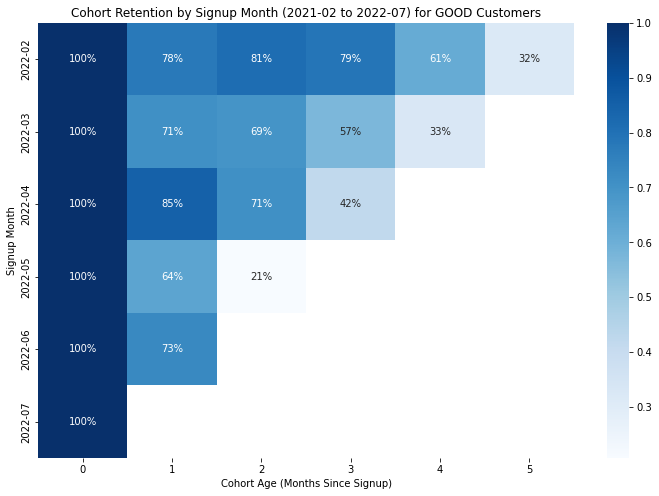

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_purchase = cp

# 필요한 칼럼 선택
customer_purchase = customer_purchase[ customer_purchase.customer_group == 'GOOD']

# 날짜 형식으로 변환
customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])

# 코호트 기준 월 추출
customer_purchase['first_join_month'] = customer_purchase['first_join_date'].dt.to_period('M')
customer_purchase['created_month'] = customer_purchase['created_at'].dt.to_period('M')

# 코호트 기간 계산
customer_purchase['cohort_period'] = customer_purchase['created_month'].astype(int) - customer_purchase['first_join_month'].astype(int)

# 필터링 - 2022년 2월 1일부터 2022년 7월 31일까지 데이터만 사용
start_date = pd.to_datetime('2022-02-01')
end_date = pd.to_datetime('2022-07-31')
customer_purchase = customer_purchase[(customer_purchase['first_join_date'] >= start_date) & (customer_purchase['first_join_date'] <= end_date)]

# 각 코호트 그룹별 고객 수 계산
cohort_group_size = customer_purchase.groupby(['first_join_month', 'cohort_period'])['customer_id'].nunique()
cohort_group_size = cohort_group_size.reset_index()

# 각 코호트 그룹별 리텐션 수 계산
cohort_retention = cohort_group_size.pivot(index='first_join_month', columns='cohort_period', values='customer_id')
cohort_size = cohort_retention.iloc[:,0]
retention_matrix = cohort_retention.divide(cohort_size, axis=0)

# 100% 초과하는 값을 100%로 변경
retention_matrix = retention_matrix.applymap(lambda x: 1 if x > 1 else x)

# 코호트 리텐션 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention by Signup Month (2021-02 to 2022-07) for GOOD Customers')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Signup Month')
plt.xticks(np.arange(6) + 0.5, labels=['0', '1', '2', '3', '4', '5'])
plt.yticks(np.arange(len(retention_matrix)) + 0.5, labels=retention_matrix.index.strftime('%Y-%m'))
plt.show()


### 일반 고객 리텐션

<ipython-input-47-36e97ab736e8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
<ipython-input-47-36e97ab736e8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
<ipython-input-47-36e97ab736e8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

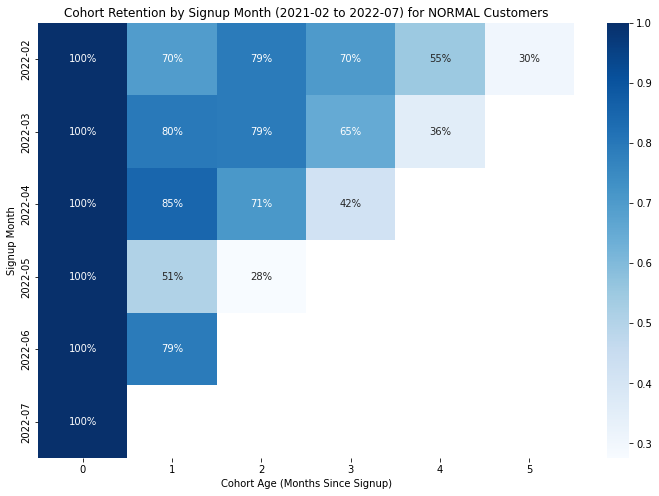

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_purchase = cp

# 필요한 칼럼 선택
customer_purchase = customer_purchase[ customer_purchase.customer_group == 'NORMAL']

# 날짜 형식으로 변환
customer_purchase['first_join_date'] = pd.to_datetime(customer_purchase['first_join_date'])
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])

# 코호트 기준 월 추출
customer_purchase['first_join_month'] = customer_purchase['first_join_date'].dt.to_period('M')
customer_purchase['created_month'] = customer_purchase['created_at'].dt.to_period('M')

# 코호트 기간 계산
customer_purchase['cohort_period'] = customer_purchase['created_month'].astype(int) - customer_purchase['first_join_month'].astype(int)

# 필터링 - 2022년 2월 1일부터 2022년 7월 31일까지 데이터만 사용
start_date = pd.to_datetime('2022-02-01')
end_date = pd.to_datetime('2022-07-31')
customer_purchase = customer_purchase[(customer_purchase['first_join_date'] >= start_date) & (customer_purchase['first_join_date'] <= end_date)]

# 각 코호트 그룹별 고객 수 계산
cohort_group_size = customer_purchase.groupby(['first_join_month', 'cohort_period'])['customer_id'].nunique()
cohort_group_size = cohort_group_size.reset_index()

# 각 코호트 그룹별 리텐션 수 계산
cohort_retention = cohort_group_size.pivot(index='first_join_month', columns='cohort_period', values='customer_id')
cohort_size = cohort_retention.iloc[:,0]
retention_matrix = cohort_retention.divide(cohort_size, axis=0)

# 100% 초과하는 값을 100%로 변경
retention_matrix = retention_matrix.applymap(lambda x: 1 if x > 1 else x)

# 코호트 리텐션 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention by Signup Month (2021-02 to 2022-07) for NORMAL Customers')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Signup Month')
plt.xticks(np.arange(6) + 0.5, labels=['0', '1', '2', '3', '4', '5'])
plt.yticks(np.arange(len(retention_matrix)) + 0.5, labels=retention_matrix.index.strftime('%Y-%m'))
plt.show()


###  리텐션 선 그래프


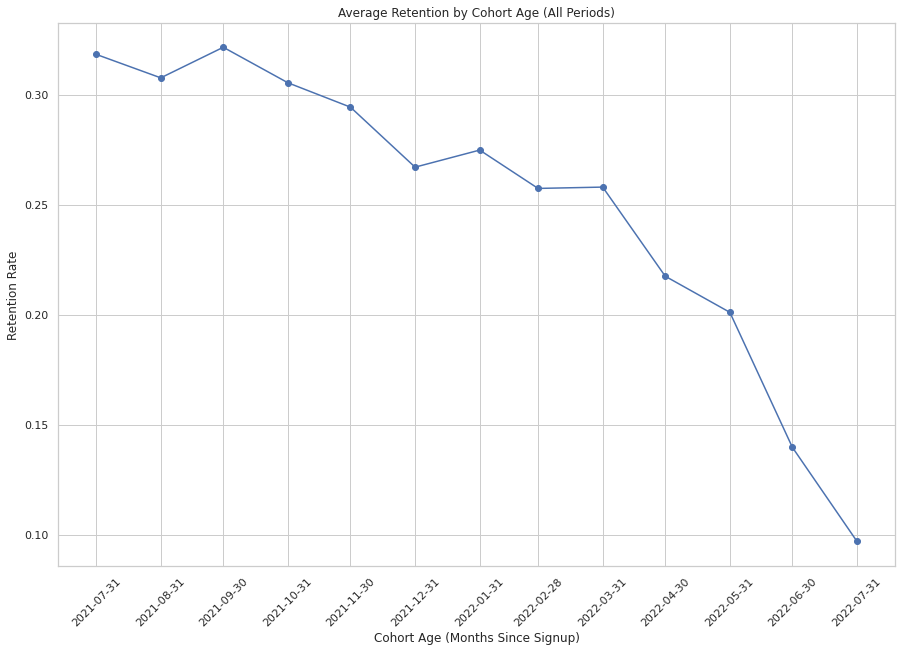

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# 전체 데이터를 사용하여 리텐션 피벗 테이블의 평균 리텐션 계산
average_retention_all = filtered_retention_pivot.mean(axis=0)

# 가입 월을 날짜 범위로 사용
cohort_dates = pd.date_range(start='2021-07', periods=13, freq='M')

# 선 그래프 시각화
plt.figure(figsize=(15,10))
plt.plot(cohort_dates, average_retention_all.tail(13), marker='o')
plt.title('Average Retention by Cohort Age (All Periods)')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Retention Rate')
plt.xticks(cohort_dates, rotation=45)
plt.show()


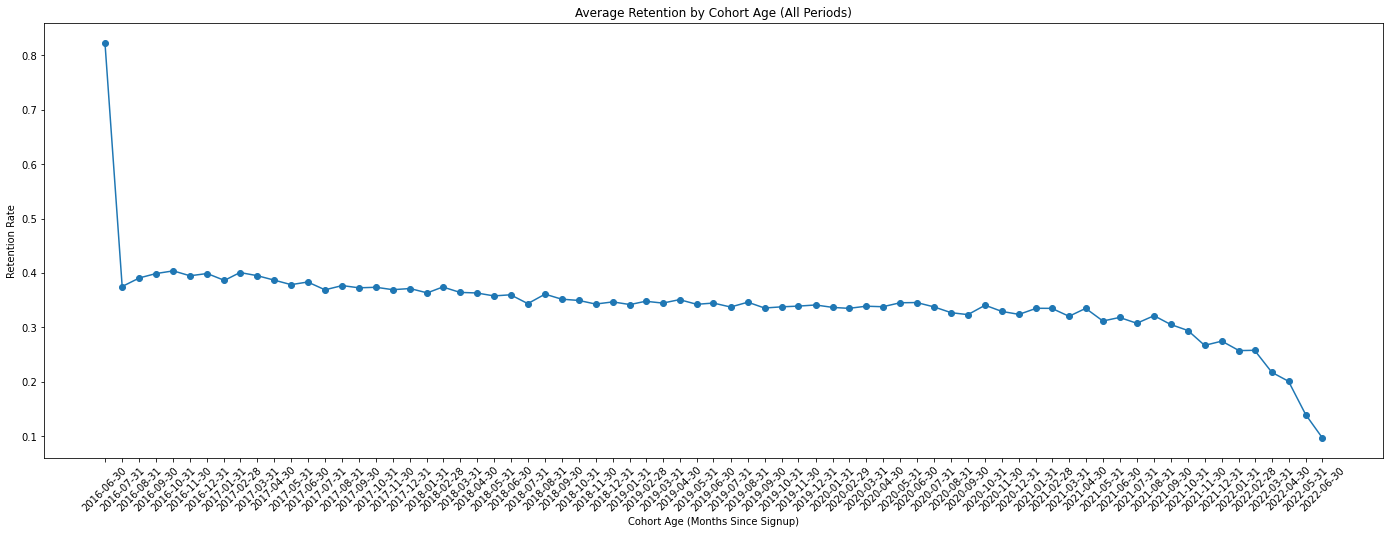

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# 전체 데이터를 사용하여 리텐션 피벗 테이블의 평균 리텐션 계산
average_retention_all = filtered_retention_pivot.mean(axis=0)

# 가입 월을 날짜 범위로 사용
cohort_dates = pd.date_range(start='2016-06', periods=len(average_retention_all), freq='M')

# 선 그래프 시각화
plt.figure(figsize=(24, 8))
plt.plot(cohort_dates, average_retention_all.values, marker='o')
plt.title('Average Retention by Cohort Age (All Periods)')
plt.xlabel('Cohort Age (Months Since Signup)')
plt.ylabel('Retention Rate')
plt.xticks(cohort_dates, rotation=45)
plt.show()


<ipython-input-84-6ea3e04ce1b6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])
/usr/local/lib/python3.9/dist-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
<ipython-input-84-6ea3e04ce1b6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])
/usr/local/lib

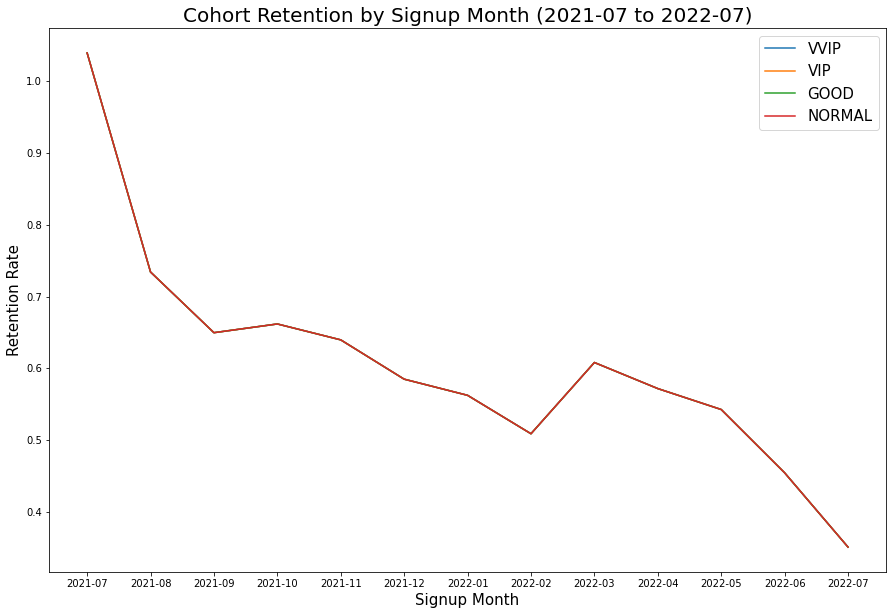

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


customer_groups = ['VVIP', 'VIP', 'GOOD', 'NORMAL']

# 새로운 그래프 생성
plt.subplots(figsize=(15, 10))

# 모든 그룹에 대해 반복
for customer_group in customer_groups:

    # 해당 그룹 데이터 추출
    customer = cu
    transaction_new = tr
    

    # 필요한 컬럼만 추출
    customer = customer[['customer_id','first_join_date']]
    transaction_new = transaction_new[['customer_id','created_at']]
    
    # 날짜 형식 변환
    customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])
    customer['first_join_month'] = customer['first_join_date'].dt.to_period('M')
    transaction_new['transaction_month'] = pd.to_datetime(transaction_new['created_at']).dt.to_period('M')

    # 코호트 연령 계산
    transaction_new = transaction_new.merge(customer[['customer_id', 'first_join_month']], on='customer_id', how='left')
    transaction_new['cohort_age'] = (transaction_new['transaction_month'] - transaction_new['first_join_month']).apply(lambda x: x.n if pd.notnull(x) else None)

    # 코호트별 고객 수 계산
    cohort_counts = customer.groupby('first_join_month').size().reset_index(name='cohort_size')

    # 코호트별 구매 건수 계산
    retention_counts = transaction_new.groupby(['first_join_month', 'cohort_age']).size().reset_index(name='transaction_count')

    # 리텐션 계산
    retention_counts = retention_counts.merge(cohort_counts, on='first_join_month')
    retention_counts['retention'] = retention_counts['transaction_count'] / retention_counts['cohort_size']

    # 기간 설정
    start_period = pd.Period('2021-07', freq='M')
    end_period = pd.Period('2022-07', freq='M')

    # 필터링된 코호트를 포함하는 retention_counts 데이터프레임 생성
    filtered_retention_counts = retention_counts[(retention_counts['first_join_month'] >= start_period) & (retention_counts['first_join_month'] <= end_period)]

    # 필터링된 retention_pivot 테이블 생성
    filtered_retention_pivot = filtered_retention_counts.pivot_table(index='first_join_month', columns='cohort_age', values='retention')

    # 새로운 고객들 제외
    cohort_sizes = customer.groupby('first_join_month').size()
    filtered_cohort_sizes = cohort_sizes[(cohort_sizes.index >= start_period) & (cohort_sizes.index <= end_period)]
    filtered_retention_pivot = filtered_retention_pivot.loc[filtered_cohort_sizes.index, :]
    

    # 시각화
    plt.plot(filtered_retention_pivot.index.astype(str), filtered_retention_pivot.mean(axis=0), label=customer_group)


plt.title('Cohort Retention by Signup Month (2021-07 to 2022-07)', fontsize=20)
plt.xlabel('Signup Month', fontsize=15)
plt.ylabel('Retention Rate', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

## 구매주기 분석
- 아이디 하나에 여러개의 구매 이력이 있으므로 각각의 구매 기간의 차이를 나타내는 purchase_diff 칼럼을 생성 
- 고객을 VVIP,VIP,GOOD,NORMAL 으로 그룹화하여 각각의 구매 주기를 비교
- 각각의 고객의 구매주기가 차이가 있는지 T-test 검정으로 확인 

In [ ]:
tr = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/transaction_new.csv")
tr['created_at'] = tr['created_at'].str.split(' ').str[0]

## customer_group 고객별 칼럼 생성
tr = tr[tr['payment_status'] == 'Success']
df = tr.groupby(['customer_id', 'created_at']).sum()
df['total_amount2'] = df['quantity'] * df['item_price']
# customer_id를 다시 칼럼으로 변환
df = df.reset_index()

# index를 0부터 시작하도록 설정
df.index = df.index - df.index.min()

# df 데이터프레임에서 total_amount2 칼럼을 기준으로 내림차순으로 정렬
df = df.sort_values(by='total_amount2', ascending=True)
# total_amount2 칼럼의 상위 4%, 16%, 30% 값을 구한다
top_4_percent = df["total_amount2"].quantile(0.96)
top_16_percent = df["total_amount2"].quantile(0.80)
top_30_percent = df["total_amount2"].quantile(0.5)

# VVIP, VIP, GOOD, NORMAL 그룹을 나눈다
def get_customer_group(row):
    if row["total_amount2"] > top_4_percent:
        return "VVIP"
    elif row["total_amount2"] > top_16_percent:
        return "VIP"
    elif row["total_amount2"] > top_30_percent:
        return "GOOD"
    else:
        return "NORMAL"

# 각 고객별 그룹을 구하고, 새로운 칼럼으로 추가한다
df["customer_group"] = df.apply(get_customer_group, axis=1)

# customer 칼럼 
cu = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/customer.csv")

## 전체 칼럼 
cu['customer_group'] = df['customer_group']
cu = cu[['first_join_date','customer_id','customer_group']]
tr = tr[['customer_id','product_id','created_at']]


In [ ]:
cu = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/cu.csv")
cu = cu[['customer_id','customer_group','first_join_date']]
tr = pd.read_csv("/content/drive/MyDrive/colab_data/Fashion Campus/tr.csv")
tr['created_at'] = tr['created_at'].str.split(' ').str[0]
tr=tr.groupby(['created_at','customer_id']).sum()
tr = tr.reset_index()
merged_df = pd.merge(tr, cu, on='customer_id', how='outer')
merged_df.dropna(subset=['created_at'], inplace=True)
merged_df = merged_df[['customer_id','customer_group','created_at']]
merged_df = merged_df[merged_df['customer_id'].isin(merged_df['customer_id'].value_counts()[merged_df['customer_id'].value_counts()>=2].index)]
merged_df

,customer_id,customer_group,created_at
0,74089,GOOD,2016-06-30
1,74089,GOOD,2017-09-18
2,74089,GOOD,2018-12-06
3,74089,GOOD,2020-02-23
4,74089,GOOD,2021-05-12
...,...,...,...
813956,82813,GOOD,2022-07-31
813963,95666,GOOD,2022-07-30
813964,95666,GOOD,2022-07-31
813966,98490,NORMAL,2022-07-30


In [ ]:
merged_df.to_csv('me.csv', index=False, encoding='utf-8-sig')

In [ ]:
customer_purchase = pd.read_csv('/content/drive/MyDrive/colab_data/Fashion Campus/customer_purchase.csv')

In [ ]:
customer_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803712 entries, 0 to 803711
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   customer_id       803712 non-null  int64 
 1   customer_group    803712 non-null  object
 2   created_at        803712 non-null  object
 3   after_created_at  803712 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.5+ MB


In [ ]:
customer_purchase['created_at'] = pd.to_datetime(customer_purchase['created_at'])
customer_purchase['after_created_at'] = pd.to_datetime(customer_purchase['after_created_at'])

customer_purchase = customer_purchase.sort_values(['customer_id', 'created_at'])
customer_purchase['purchase_diff'] = (customer_purchase['after_created_at'] - customer_purchase['created_at']).dt.days

customer_purchase = customer_purchase[['customer_id', 'customer_group', 'created_at', 'after_created_at', 'purchase_diff']]

last_indices = customer_purchase.sort_values(['customer_id', 'created_at']).groupby('customer_id').tail(1).index
customer_purchase = customer_purchase.drop(last_indices)

In [ ]:
customer_purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763832 entries, 351514 to 315333
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       763832 non-null  int64         
 1   customer_group    763832 non-null  object        
 2   created_at        763832 non-null  datetime64[ns]
 3   after_created_at  763832 non-null  datetime64[ns]
 4   purchase_diff     763832 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 35.0+ MB


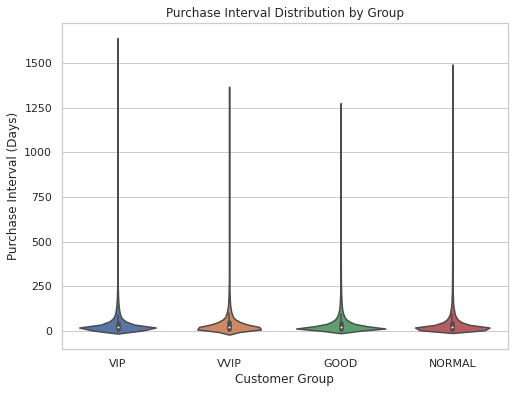

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# VIP와 VVIP 그룹의 구매 주기 데이터 추출
vip_data = customer_purchase[customer_purchase['customer_group']=='VIP']['purchase_diff']
vvip_data = customer_purchase[customer_purchase['customer_group']=='VVIP']['purchase_diff']
GOOD_data = customer_purchase[customer_purchase['customer_group']=='GOOD']['purchase_diff']
NORMAL_data = customer_purchase[customer_purchase['customer_group']=='NORMAL']['purchase_diff']

# 데이터 프레임 생성
data = pd.DataFrame({'VIP': vip_data, 'VVIP': vvip_data, 'GOOD': GOOD_data, 'NORMAL': NORMAL_data})

# 데이터 구조 변경
data = pd.melt(data, var_name='Group', value_name='Purchase Interval (Days)')

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(x='Group', y='Purchase Interval (Days)', data=data, ax=ax)
ax.set_title('Purchase Interval Distribution by Group')
ax.set_xlabel('Customer Group')
ax.set_ylabel('Purchase Interval (Days)')
plt.show()


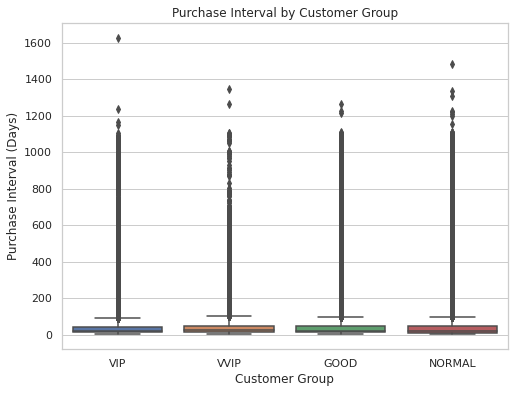

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# VIP와 VVIP 그룹의 구매 주기 데이터 추출
vip_data = customer_purchase[customer_purchase['customer_group']=='VIP']['purchase_diff']
vvip_data = customer_purchase[customer_purchase['customer_group']=='VVIP']['purchase_diff']
GOOD_data = customer_purchase[customer_purchase['customer_group']=='GOOD']['purchase_diff']
NORMAL_data = customer_purchase[customer_purchase['customer_group']=='NORMAL']['purchase_diff']

# 데이터 프레임 생성
data = pd.DataFrame({'VIP': vip_data, 'VVIP': vvip_data, 'GOOD': GOOD_data, 'NORMAL': NORMAL_data})

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(data), ax=ax)
ax.set_title('Purchase Interval by Customer Group')
ax.set_xlabel('Customer Group')
ax.set_ylabel('Purchase Interval (Days)')
plt.show()


### 고객별 평균 구매 주기

In [ ]:
mean_purchase_diff = customer_purchase.groupby('customer_group')['purchase_diff'].mean()
print(mean_purchase_diff)

customer_group
GOOD      44.685711
NORMAL    44.244854
VIP       44.405491
VVIP      46.301459
Name: purchase_diff, dtype: float64


### 고객별 분포 비율 

In [ ]:
customer_purchase.customer_group.value_counts(normalize=True)

NORMAL    0.502429
GOOD      0.299220
VIP       0.161029
VVIP      0.037322
Name: customer_group, dtype: float64

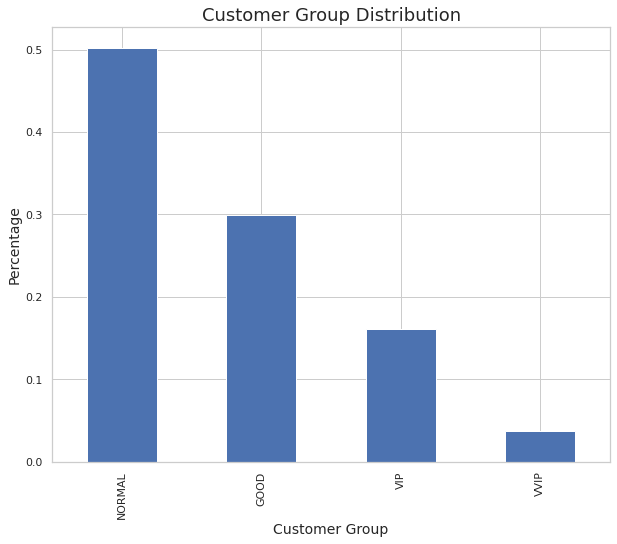

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 고객 그룹별 구매 주기 분포 그래프
customer_purchase.customer_group.value_counts(normalize=True).plot(kind='bar')
plt.gcf().set_size_inches(10, 8)
plt.title('Customer Group Distribution', fontsize=18)
plt.xlabel('Customer Group', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.show()


### 구매 주기 연도-월별 트렌드 그래프 

In [ ]:
line_plot_year = customer_purchase
line_plot_month = customer_purchase

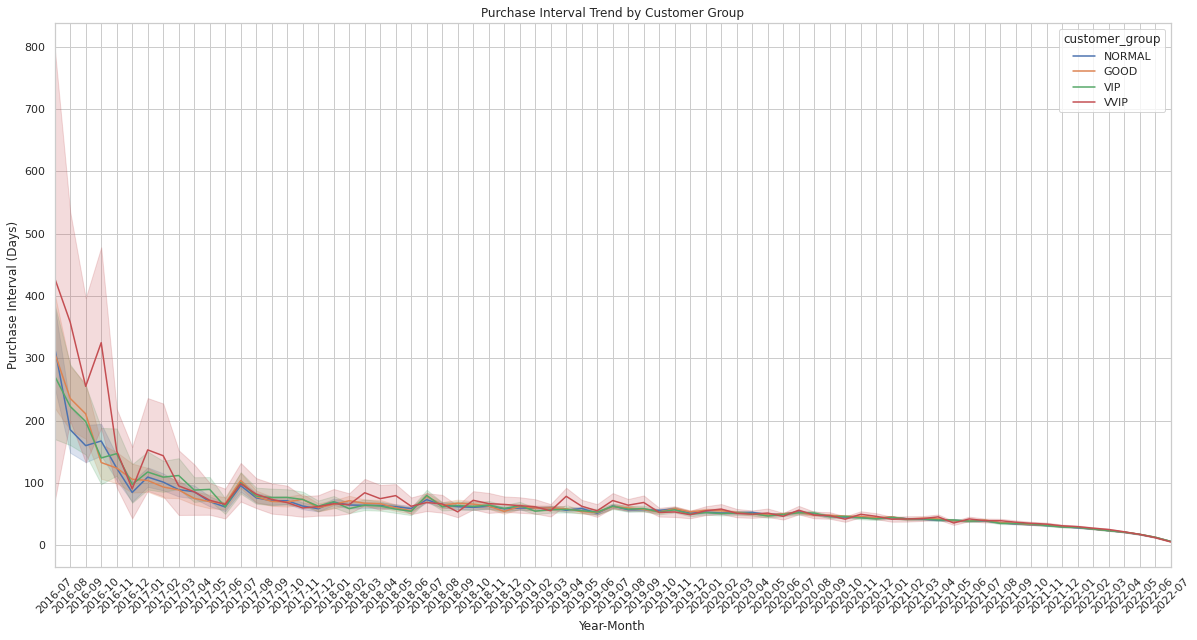

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 전처리
line_plot_year['year_month'] = line_plot_year['created_at'].dt.strftime('%Y-%m')
line_plot_year = line_plot_year[line_plot_year['year_month'] >= '2016-07']  # 2016년 7월 이후 데이터만 선택
line_plot_year = line_plot_year.sort_values('year_month')  # x축 레이블 정렬

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='year_month', y='purchase_diff', hue='customer_group', data=line_plot_year, ax=ax)
ax.set_title('Purchase Interval Trend by Customer Group')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Purchase Interval (Days)')
plt.xticks(rotation=45)  # x축 레이블 회전
ax.set_xlim('2016-07', '2022-07')  # x축 범위 설정
plt.show()


<ipython-input-170-a66409691c8e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot_month['year_month'] = line_plot_month['created_at'].dt.strftime('%Y-%m')


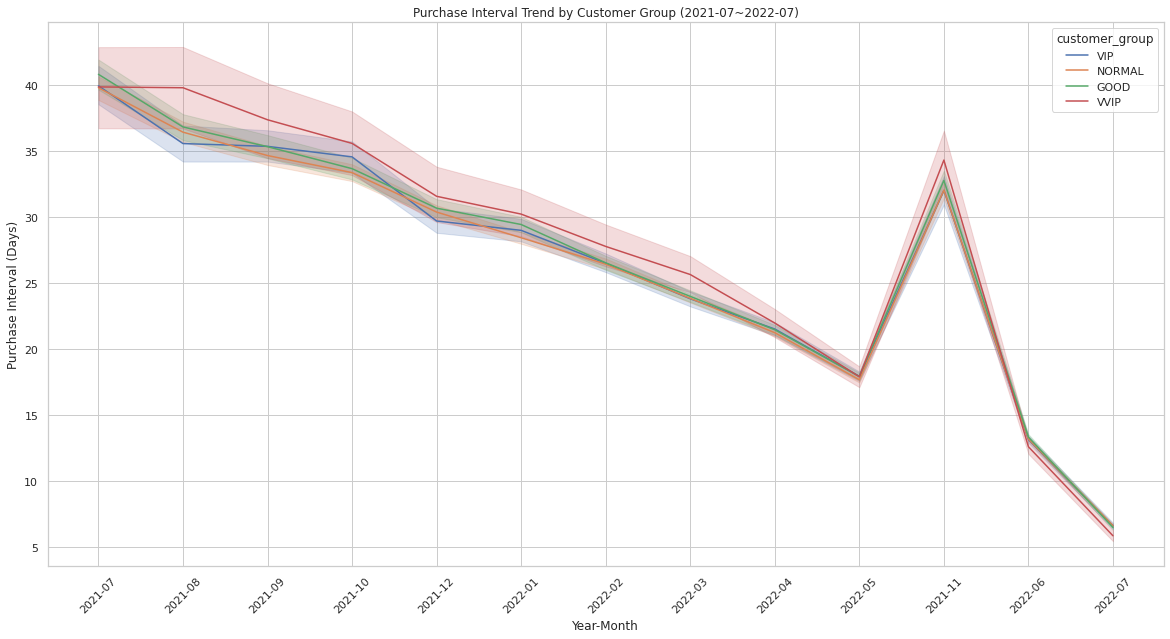

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 전처리
line_plot_month['year_month'] = line_plot_month['created_at'].dt.strftime('%Y-%m')
line_plot_month = line_plot_month[line_plot_month['year_month'] >= '2021-07']  # 2021년 7월 이후 데이터만 선택

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='year_month', y='purchase_diff', hue='customer_group', data=line_plot_month, ax=ax)
ax.set_title('Purchase Interval Trend by Customer Group (2021-07~2022-07)')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Purchase Interval (Days)')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()


In [ ]:
line_plot_month[line_plot_month.year_month == '2022-07']

,customer_id,customer_group,created_at,after_created_at,purchase_diff,year_month,year,month
763144,20,NORMAL,2022-07-01,2022-07-06,5,2022-07,2022,7
763145,20,NORMAL,2022-07-06,2022-07-11,5,2022-07,2022,7
763146,20,NORMAL,2022-07-11,2022-07-16,5,2022-07,2022,7
802526,102,GOOD,2022-07-17,2022-07-22,5,2022-07,2022,7
802527,102,GOOD,2022-07-22,2022-07-27,5,2022-07,2022,7
...,...,...,...,...,...,...,...,...
488046,99915,NORMAL,2022-07-19,2022-07-26,7,2022-07,2022,7
788015,99936,VIP,2022-07-04,2022-07-19,15,2022-07,2022,7
613843,99976,VIP,2022-07-03,2022-07-14,11,2022-07,2022,7
624925,99995,NORMAL,2022-07-05,2022-07-17,12,2022-07,2022,7


### 고객별 T-test 검정 

In [ ]:
import pandas as pd
from scipy import stats

# VIP와 VVIP 그룹의 평균 구매 주기 차이 검정
ttest_vip_vvip = stats.ttest_ind(customer_purchase[customer_purchase['customer_group'] == 'VIP']['purchase_diff'],
                                 customer_purchase[customer_purchase['customer_group'] == 'VVIP']['purchase_diff'],
                                 equal_var=False)

# GOOD와 NORMAL 그룹의 평균 구매 주기 차이 검정
ttest_good_normal = stats.ttest_ind(customer_purchase[customer_purchase['customer_group'] == 'GOOD']['purchase_diff'],
                                    customer_purchase[customer_purchase['customer_group'] == 'NORMAL']['purchase_diff'],
                                    equal_var=False)

# 모든 그룹 조합에 대한 t-test 실행
group_names = ['VVIP', 'VIP', 'GOOD', 'NORMAL']
ttest_results = pd.DataFrame(index=group_names, columns=group_names)

for group1 in group_names:
    for group2 in group_names:
        ttest_result = stats.ttest_ind(customer_purchase[customer_purchase['customer_group'] == group1]['purchase_diff'],
                                       customer_purchase[customer_purchase['customer_group'] == group2]['purchase_diff'],
                                       equal_var=False)
        ttest_pvalue = round(ttest_result[1], 4)  # p-value 반올림
        ttest_results.loc[group1, group2] = ttest_pvalue

print(ttest_results)


          VVIP     VIP    GOOD  NORMAL
VVIP       1.0  0.0002  0.0009     0.0
VIP     0.0002     1.0  0.2914  0.5157
GOOD    0.0009  0.2914     1.0  0.0253
NORMAL     0.0  0.5157  0.0253     1.0


<Axes: >

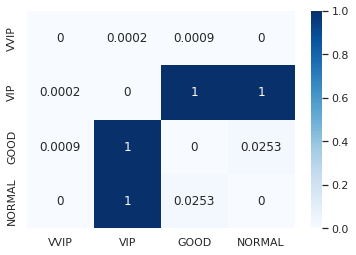

In [ ]:
import pandas as pd
from scipy import stats
import itertools
import seaborn as sns

# 고객 그룹별 T-test 진행
groups = ['VVIP', 'VIP', 'GOOD', 'NORMAL']
p_values = []
for group1, group2 in itertools.combinations(groups, 2):
    ttest = stats.ttest_ind(customer_purchase[customer_purchase['customer_group']==group1]['purchase_diff'],
                            customer_purchase[customer_purchase['customer_group']==group2]['purchase_diff'], 
                            equal_var=False)
    if ttest.pvalue >= 0.05:
        p_values.append(1)
    else:
        p_values.append(round(ttest.pvalue, 4))

# 혼동행렬 생성
confusion_matrix = pd.DataFrame([[1] * 4]*4, columns=groups, index=groups)
confusion_matrix.values[[0,1,2,3],[0,1,2,3]] = 0
for i, j in itertools.combinations(range(len(groups)), 2):
    confusion_matrix.iloc[j, i] = p_values.pop(0)
    confusion_matrix.iloc[i, j] = confusion_matrix.iloc[j, i]

# 시각화
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.4g')


## 최근 1년 구매 주기 분석 
- 2021-07 ~ 2022-07

In [ ]:
# 최근 1년 데이터만 선택
recent_data = customer_purchase[customer_purchase['created_at'] >= '2022-07-01']

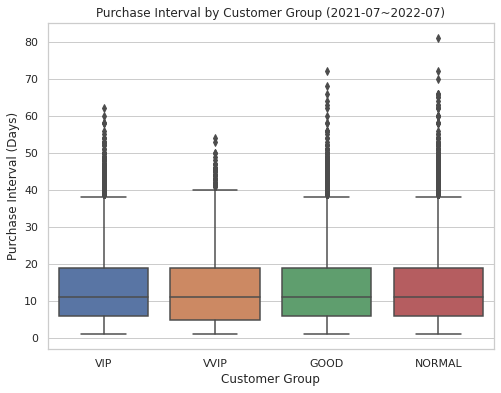

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# VIP와 VVIP 그룹의 구매 주기 데이터 추출
vip_data = recent_data[recent_data['customer_group']=='VIP']['purchase_diff']
vvip_data = recent_data[recent_data['customer_group']=='VVIP']['purchase_diff']
GOOD_data = recent_data[recent_data['customer_group']=='GOOD']['purchase_diff']
NORMAL_data = recent_data[recent_data['customer_group']=='NORMAL']['purchase_diff']

# 데이터 프레임 생성
data = pd.DataFrame({'VIP': vip_data, 'VVIP': vvip_data, 'GOOD': GOOD_data, 'NORMAL': NORMAL_data})

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(data), ax=ax)
ax.set_title('Purchase Interval by Customer Group (2021-07~2022-07)')
ax.set_xlabel('Customer Group')
ax.set_ylabel('Purchase Interval (Days)')
plt.show()


### 최근 1년 고객별 평균 구매 주기

In [ ]:
mean_recent_data_diff = recent_data.groupby('customer_group')['purchase_diff'].mean()
print(mean_recent_data_diff)

customer_group
GOOD      6.464597
NORMAL    6.596399
VIP       6.596164
VVIP      5.831068
Name: purchase_diff, dtype: float64


### 최근 1년 고객별 T-test 검정 

In [ ]:
import pandas as pd
from scipy import stats

# VIP와 VVIP 그룹의 평균 구매 주기 차이 검정
ttest_vip_vvip = stats.ttest_ind(recent_data[recent_data['customer_group'] == 'VIP']['purchase_diff'],
                                 recent_data[recent_data['customer_group'] == 'VVIP']['purchase_diff'],
                                 equal_var=False)

# GOOD와 NORMAL 그룹의 평균 구매 주기 차이 검정
ttest_good_normal = stats.ttest_ind(recent_data[recent_data['customer_group'] == 'GOOD']['purchase_diff'],
                                    recent_data[recent_data['customer_group'] == 'NORMAL']['purchase_diff'],
                                    equal_var=False)

# 모든 그룹 조합에 대한 t-test 실행
group_names = ['VVIP', 'VIP', 'GOOD', 'NORMAL']
ttest_results = pd.DataFrame(index=group_names, columns=group_names)

for group1 in group_names:
    for group2 in group_names:
        ttest_result = stats.ttest_ind(recent_data[recent_data['customer_group'] == group1]['purchase_diff'],
                                       recent_data[recent_data['customer_group'] == group2]['purchase_diff'],
                                       equal_var=False)
        ttest_pvalue = round(ttest_result[1], 4)  # p-value 반올림
        ttest_results.loc[group1, group2] = ttest_pvalue

print(ttest_results)


          VVIP     VIP    GOOD  NORMAL
VVIP       1.0  0.0091  0.0102  0.0342
VIP     0.0091     1.0  0.7773  0.2019
GOOD    0.0102  0.7773     1.0  0.2287
NORMAL  0.0342  0.2019  0.2287     1.0


<Axes: >

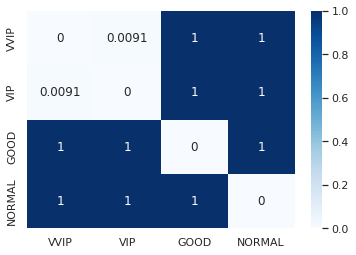

In [ ]:
import pandas as pd
from scipy import stats
import itertools
import seaborn as sns

# 고객 그룹별 T-test 진행
groups = ['VVIP', 'VIP', 'GOOD', 'NORMAL']
p_values = []
for group1, group2 in itertools.combinations(groups, 2):
    ttest = stats.ttest_ind(recent_data[recent_data['customer_group']==group1]['purchase_diff'],
                            recent_data[recent_data['customer_group']==group2]['purchase_diff'], 
                            equal_var=False)
    if ttest.pvalue >= 0.01:
        p_values.append(1)
    else:
        p_values.append(round(ttest.pvalue, 4))

# 혼동행렬 생성
confusion_matrix = pd.DataFrame([[1] * 4]*4, columns=groups, index=groups)
confusion_matrix.values[[0,1,2,3],[0,1,2,3]] = 0
for i, j in itertools.combinations(range(len(groups)), 2):
    confusion_matrix.iloc[j, i] = p_values.pop(0)
    confusion_matrix.iloc[i, j] = confusion_matrix.iloc[j, i]

# 시각화
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.4g')
